# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
import warnings

In [8]:
from sklearn.decomposition import PCA

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [11]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [12]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [13]:
def simplify_name(name):
    return name.split('.')[0]

In [14]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

In [163]:
temp_adata = adata.copy()
# temp_adata = temp_adata[temp_adata.obs.cell == ct].copy()
norm_temp_adata = temp_adata.copy()
sc.pp.normalize_total(norm_temp_adata, target_sum=1e4)
sc.pp.log1p(norm_temp_adata)

In [15]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [16]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


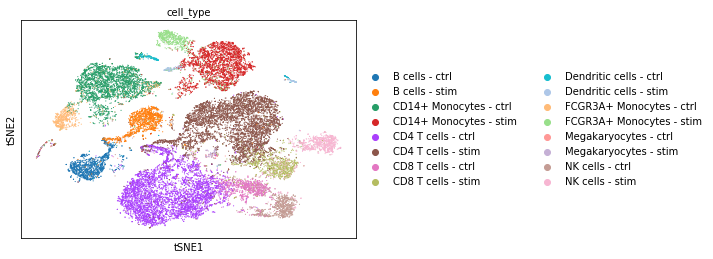

In [17]:
sc.pl.tsne(adata, color='cell_type')

In [18]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [19]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [20]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Cell type specific co-expression

gene_1, gene_2 = 'CXCR4', 'EEF1D'

gene_1, gene_2 = 'CXCR4', 'EEF1A1'

gene_1, gene_2 = 'PFDN5', 'OAZ1'

gene_1, gene_2 = 'UBB', 'OAZ1'




In [21]:
adata.shape

(24673, 35635)

In [151]:
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(estimator)

ct = 'CD4 T cells'
adata_ct =  adata[adata.obs.stim == 'ctrl'].copy()
adata_ct.obs['ct'] = adata_ct.obs['cell'].apply( lambda x: int(x == ct))# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
# adata_ct.obs['ct'] = adata_ct.obs['ct'][np.random.choice(adata_ct.shape[0],adata_ct.shape[0], replace=False)].values
scmemo.create_groups(adata_ct, label_columns=['ct', 'ind'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=1, 
    min_perc_group=0.99)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
target_genes = [gene for gene in target_genes if gene[:2] != 'RP' and gene[:3] != 'HLA']
# target_genes = np.random.choice(target_genes, 50)
print('TF list length', len(available_tfs))
print('target gene length', len(target_genes))
scmemo.compute_2d_moments(adata_ct, target_genes, target_genes)

Size of data (12315, 101)
TF list length 0
target gene length 34


In [152]:
%%time
scmemo.ht_2d_moments(adata_ct, formula_like='1 + ct', cov_column='ct', num_boot=1000)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s


CPU times: user 10min 38s, sys: 9.42 s, total: 10min 47s
Wall time: 8min 17s


[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:  8.3min finished


In [153]:
df = scmemo.get_2d_ht_result(adata_ct)

In [187]:
df.query('corr_fdr < 0.1').sort_values('corr_coef', ascending=False).head(30)

,gene_1,gene_2,corr_coef,corr_pval,corr_fdr
983,UBB,OAZ1,0.906432,1.410781e-07,2.186711e-06
1082,OAZ1,UBB,0.906432,1.410781e-07,2.186711e-06
779,UBC,OAZ1,0.903240,5.520970e-08,1.360401e-06
1076,OAZ1,UBC,0.903240,5.520970e-08,1.360401e-06
479,FTH1,PTMA,0.831490,6.105011e-06,3.093597e-05
116,PTMA,FTH1,0.831490,6.105011e-06,3.093597e-05
82,CXCR4,FTH1,0.822315,1.916553e-07,2.734269e-06
478,FTH1,CXCR4,0.822315,1.916553e-07,2.734269e-06
81,CXCR4,SRGN,0.707267,4.926859e-08,1.360401e-06
444,SRGN,CXCR4,0.707267,4.926859e-08,1.360401e-06


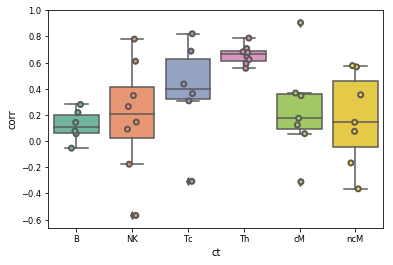

In [195]:

gene_1, gene_2 = 'UBC', 'EIF1'
sns.boxplot(x='ct', y='corr',
    data=get_ct_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='ct', y='corr',
    data=get_ct_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', linewidth=2)

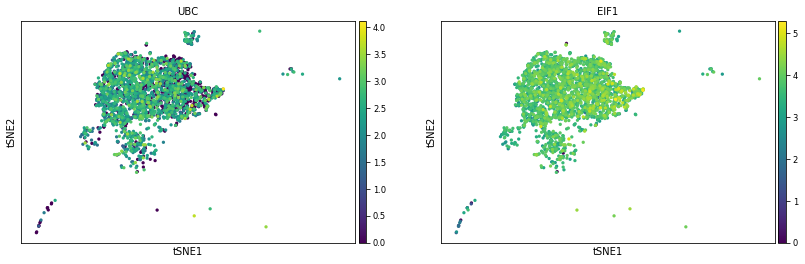

In [196]:
sc.pl.tsne(norm_temp_adata[(norm_temp_adata.obs.stim == 'ctrl') & (norm_temp_adata.obs.cell == 'CD14+ Monocytes')], color=[gene_1, gene_2])

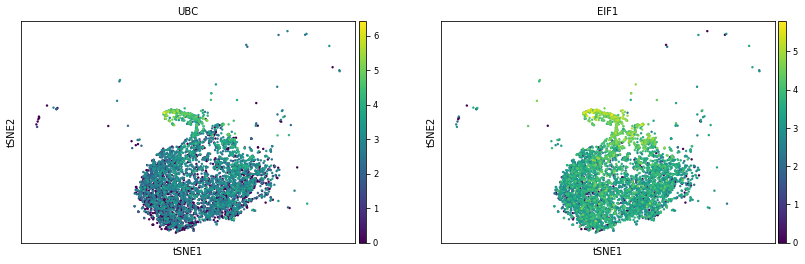

In [197]:
sc.pl.tsne(norm_temp_adata[(norm_temp_adata.obs.stim == 'ctrl') & (norm_temp_adata.obs.cell == 'CD4 T cells')], color=[gene_1, gene_2])

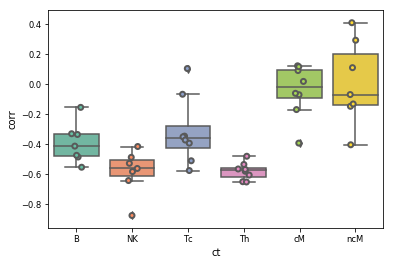

In [133]:
gene_1, gene_2 = 'MALAT1', 'RPL3'
sns.boxplot(x='ct', y='corr',
    data=get_ct_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='ct', y='corr',
    data=get_ct_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', linewidth=2)

In [90]:
def plot_gene_product(adata, gene_1, gene_2):
    adata.obs['temp'] = np.log(adata_ct[:, gene_1].X.toarray()*adata_ct[:, gene_2].X.toarray() + 1)
    sc.pl.tsne(adata, color='temp')
    
def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell', 'stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.125, 
        min_perc_group=0.99)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    df = pd.DataFrame(df_list, columns=['ct', 'stim','ind', 'corr']).sort_values('ct')
    df['corr'] = df['corr'].apply(lambda x: np.nan if abs(x) > 1 else x)
    
    return df

In [ ]:
for idx, row in df.query('corr_fdr < 0.1').sort_values('corr_coef', ascending=False).head(100).iterrows():
    plt.figure(figsize=(5, 3))
    sns.boxplot(x='ct', y='corr', hue='stim',
                data=get_ct_ind_corr(adata_ct, row['gene_1'], row['gene_2']), 
                palette='Set2')
    sns.stripplot(x='ct', y='corr', hue='stim',
                data=get_ct_ind_corr(adata_ct, row['gene_1'], row['gene_2']), 
                dodge=True, linewidth=2, palette='Set2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('{}/{}/'.format(row['gene_1'], row['gene_2']))